In [1]:
import torch
import torchvision
from torchvision import models, transforms

In [2]:
print(f'torch version: {torch.__version__}')
print(f'torchvision version: {torchvision.__version__}')

torch version: 1.9.0+cu111
torchvision version: 0.10.0+cu111


In [3]:
use_pretrained = True
net = models.vgg16(pretrained=use_pretrained)
net.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [4]:
print(net)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## 전이학습

### 구현 초기 설정

In [5]:
import glob
import os.path as osp
import random
import json
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

### 데이터 셋 작성

In [6]:
# __call__()은 파이썬의 일반 메서드입니다.
# 해당 클래스의 인스턴스를 구체적인 함수를 지정하지 않고 호출하면 실행되는 함수
# ImageTransform의 인스턴스를 생성한 후 함수를 지정하지 않고 인스턴스명으로 실행하면 __call__()이 실행됩니다.

class ImageTransform():
    
    '''
    화상 전처리 클래스. 훈련 시, 검증 시의 동작이 다르다.
    화상 크기를 리사이즈 하고 색상을 표준화한다.
    훈련 시에는 RandomResizedCrop과 RandomHorizontalFlip으로 데이터를 확장(data augmentation)한다
    
    Attributes
    ----------
    resize : int
        리사이즈 대상 화상의 크기
    mean : (R, G, B)
        각 색상 채널의 평균 값
    std : (R, G, B)
        각 색상 채널의 표준편차
    '''
    
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                # 데이터 확장, scale에 지정된 0.5~1.0 크기로 화상을 확대 및 축소하고 마지막으로 resize에서 지정한 크기로 화상을 자릅니다.
                transforms.RandomResizedCrop( 
                    resize, scale=(0.5, 1.0)),
                # 데이터 확장, 화상의 좌우를 50%의 확률로 반전
                transforms.RandomHorizontalFlip(),
                # 텐서로 변환
                transforms.ToTensor(),
                # 표준화
                transforms.Normalize(mean, std)
            ]),
            'val': transforms.Compose([
                # 리사이즈
                transforms.Resize(resize),
                # 화상 중앙을 resize x resize로 자른다
                transforms.CenterCrop(resize),
                # 텐서로 변환
                transforms.ToTensor(),
                # 표준화
                transforms.Normalize(mean, std)
            ])
        }
        
    def __call__(self, img, phase='train'):
        '''
        Parameters
        ----------
        phase : 'train' or 'val'
            전처리 모드 지정
        '''
        return self.data_transform[phase](img)

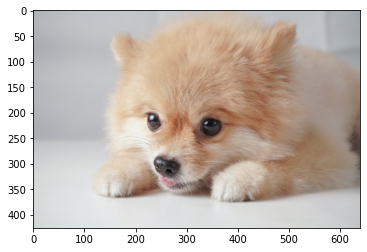

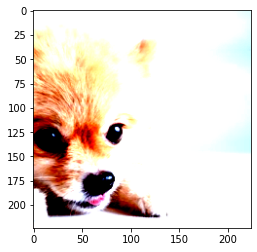

In [7]:
# 훈련 시 화상 전처리 동작 확인
# 실행할 때 마다 처리 결과 화상이 바뀐다

# 1. 화상 읽기
image_file_path = '../test_data/catdog/111500268.2.jpg'
img = Image.open(image_file_path)

# 2. 원본 화상 표시
plt.imshow(img)
plt.show()

# 3. 화상 전처리, 처리된 화상 표시
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = ImageTransform(size, mean, std)
img_transformed = transform(img, phase='train') # torch.Size([3, 224, 224])

# (색상, 높이, 너비)를 (높이, 너비, 색상)으로 변환하고 0-1로 값을 제한해 표시
img_transformed = img_transformed.numpy().transpose((1, 2, 0))
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()

In [8]:
# 볶음밥과 김밥의 화상 파일 경로 리스트 작성
def make_datapath_list(phase='train'):
    '''
    데이터의 경로를 저장한 리스트 작성
    
    Parameters
    ----------
    phase : 'train' or 'val'
        훈련 데이터 또는 검증 데이터 지정
    
    Returns
    -------
    path_list : list
        데이터 경로를 저장한 리스트
    '''
    rootpath = '../img_data/'
    target_path = osp.join(rootpath+phase+'/**/*.jpg')
    print(target_path)
    
    path_list = [] # 여기에 저장
    
    # glob을 이용하여 하위 디럭토리의 파일 경로를 가져온다
    for path in glob.glob(target_path):
        path_list.append(path)
    
    return path_list

In [9]:
# rootpath = '../img_data/'
# phase = 'train' or 'val'
# data에 따른 폴더명
train_list = make_datapath_list(phase='train')
val_list = make_datapath_list(phase='val')

train_list

../img_data/train/**/*.jpg
../img_data/val/**/*.jpg


['../img_data/train/kimb/kim-rice-687172__340.jpg',
 '../img_data/train/kimb/201686336_1280.jpg',
 '../img_data/train/kimb/images (1).jpg',
 '../img_data/train/kimb/0639f16dfeb0a.jpg',
 '../img_data/train/kimb/IMG_3809.jpg',
 '../img_data/train/kimb/e907ec6953082.jpg',
 '../img_data/train/kimb/235E2B4D56E6C0AB03.jpg',
 '../img_data/train/kimb/29OEGRPM9T_1.jpg',
 '../img_data/train/kimb/5f9e9bf3-0482-4dd0-9738-9667cf561767.jpg',
 '../img_data/train/kimb/maxresdefault.jpg',
 '../img_data/train/kimb/pixta_65991015_M.jpg',
 '../img_data/train/kimb/2c69159b-a878-4d8e-a834-8a1a7440db1b.jpg',
 '../img_data/train/kimb/images.jpg',
 '../img_data/train/kimb/PS22081300539.jpg',
 '../img_data/train/kimb/ff51e88db276ca530d059550653c36a01.jpg',
 '../img_data/train/kimb/images (2).jpg',
 '../img_data/train/bibim/B010316XX_02334.jpg',
 '../img_data/train/bibim/20220628_M7O_1656371902441_626Kb.jpg',
 '../img_data/train/bibim/B010316XX_02355.jpg',
 '../img_data/train/bibim/B010316XX_02358.jpg',
 '../img

In [10]:
train_list[0].split('/')[3]

'kimb'

In [11]:
# 비빔밥과 김밥에 대한 Dataset 작성

class ImgdataDataset(data.Dataset):
    '''
    Dataset 클래스. 파이토치의 Dataset 클래스 상속
    
    Attributes
    ----------
    file_list : 리스트
        화상 경로를 저장한 리스트
    transform : object
        전처리 클래스의 인스턴스
    phase : 'train' or 'val'
        학습인지 훈련인지 설정
    '''
    
    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list # 파일 경로 리스트
        self.transform = transform # 전처리 클래스의 인스턴스
        self.phase = phase # train or val 지정
    
    def __len__(self):
        '''화상 개수를 반환'''
        return len(self.file_list)
    
    def __getitem__(self, index):
        '''
        전처리한 화상의 텐서 형식의 데이터와 라벨 취득
        '''
         # index번째의 화상 로드
        img_path = self.file_list[index]
        img = Image.open(img_path) # [높이][폭][색RGB]
        
        # 화상의 전처리 실시
        img_transformed = self.transform(
            img, self.phase) # torch.Size([3, 224, 224])
        
        # 화상 라벨을 파일 이름에서 추출
        label = img_path.split('/')[3]

        # 라벨을 숫자로 변경
        if label == 'kimb':
            label = 0
        elif label == 'bibim':
            label = 1
            
        return img_transformed, label

# 실행
train_dataset = ImgdataDataset(
    file_list=train_list, transform=ImageTransform(size, mean, std), phase='train')
val_dataset = ImgdataDataset(
    file_list=val_list, transform=ImageTransform(size, mean, std), phase='val')

# 동작확인
index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 224, 224])
0


### 데이터 로더 작성

In [12]:
# 미니 배치 크기 지정
batch_size = 32

# 데이터 로더 작성
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# 양자를 사전형 변수에 정리
dataloaders_dict = {'train': train_dataloader, 'val': val_dataloader}

# 동작 확인
batch_iterator = iter(dataloaders_dict['train']) # 반복자(iterator)로 변환
inputs, labels = next(
    batch_iterator) # 첫 번째 요소 추출
print(inputs.size())
print(labels)

torch.Size([32, 3, 224, 224])
tensor([1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0,
        0, 1, 1, 1, 1, 1, 1, 1])


### 네트워크 모델 작성

In [13]:
# 학습된 VGG-16 모델 로드
# VGG-16 모델의 인스턴스 작성
use_pretrained = True # 학습된 파라미터 사용
net = models.vgg16(pretrained=use_pretrained)

# VGG16의 마지막 출력층의 출력 유닛을 비빔밥과 김밥인 두 개로 변경
net.classifier[6] = nn.Linear(in_features=4096, out_features=2)

# 훈련 모드로 설정
net.train()

print('네트워크 설정 완료: 학습된 가중치를 읽어들여 훈련 모드로 설정했습니다.')

네트워크 설정 완료: 학습된 가중치를 읽어들여 훈련 모드로 설정했습니다.


### 손실함수 정의

In [14]:
# 손실함수 설정
criterion = nn.CrossEntropyLoss()

### 최적화 기법 설정

In [15]:
# 전이학습에서 학습시킬 파라미터를 params_to_update 변수에 저장
params_to_update = []

# 학습시킬 파라미터명
update_param_names = ['classifier.6.weight', 'classifier.6.bias']

# 학습시킬 파라미터 외에는 경사를 계산하지 않고 변하지 않도록 설정
for name, param in net.named_parameters():
    if name in update_param_names:
        # requires_grad = True로 설정한 파라미터는 오차 역전파로 경사를 계산하여 학습 시에 값이 변합니다.
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else:
        # requires_grad = False는 파라미터를 고정시켜 갱신하지 않도록 설정
        param.requires_grad = False

# params_to_update의 내용 확인
print('---------------')
print(params_to_update)

classifier.6.weight
classifier.6.bias
---------------
[Parameter containing:
tensor([[ 0.0085,  0.0005,  0.0085,  ...,  0.0143, -0.0025, -0.0015],
        [-0.0156,  0.0137, -0.0017,  ...,  0.0142,  0.0102,  0.0097]],
       requires_grad=True), Parameter containing:
tensor([-0.0143, -0.0098], requires_grad=True)]


In [16]:
# 최적화 기법
optimizer = optim.Adam(params=params_to_update, lr=0.001)

### 학습 및 검증 실시
- 파이토치에서 학습과 검증으로 네트워크 모드를 전환하는 것은 드롭아웃 층과 같이 학습 및 검증에 동작이 서로 다른 층이 있기 때문이다.
- loss에는 미니 배치로 평균 손실이 저장되었습니다. 이 값을 .item()으로 꺼냅니다. 손실은 미니 배치 크기의 평균값으로 되어 미니 배치의 크기인 input.size(0) = 32를 곱해서 미니 배치의 총 손실을 구합니다.

In [17]:
# 모델을 학습시키는 함수 작성
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    
    # 에폭 루프
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')
        
        # 에폭별 학습 및 검증 루프
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train() # 모델을 학습 모드로
            elif phase == 'val':
                net.eval() # 모델을 검증 모드로
                
            epoch_loss = 0.0 # 에폭 손실 합
            epoch_correts = 0 # 에폭 정답 수
            
            # 학습하지 않을 시 검증 성능을 확인하기 위해 epoch=0의 훈련 생략
            if (epoch == 0) and (phase == 'train'):
                continue
            
            # 데이터 로더로 미니 배치를 꺼내는 루프
            for inputs, labels in tqdm(dataloaders_dict[phase]):
                
                # 옵티마이저 초기화
                optimizer.zero_grad()
                
                # torch.set_grad_enabled(phase=='train'): 은 학습시에만 경사를 계산하는 설정, 검증 시에는 경사를 계산할 필요가 없어 생략
                # 순전파 계산
                with torch.set_grad_enabled(phase=='train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels) # 손실 계산
                    _, preds = torch.max(outputs, 1) # 라벨 예측
                    
                    # 훈련 시에는 오차 역전파
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                    # 반복 결과 계산
                    # 손실 합계 갱신
                    epoch_loss += loss.item() * inputs.size(0)
                    # 정답 수의 합계 갱신
                    epoch_correts += torch.sum(preds == labels.data)
                    
                    # 에폭당 손실과 정답 표시
                    epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
                    epoch_acc = epoch_correts.double() / len(dataloaders_dict[phase].dataset)
                    
                    print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

In [18]:
# 학습 및 검증 실시
num_epoch = 2
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epoch)

Epoch 1/2
-------------


  0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 1/1 [00:00<00:00,  1.98it/s]


val Loss: 0.7718 Acc: 0.3333
Epoch 2/2
-------------


 50%|█████     | 1/2 [00:02<00:02,  2.64s/it]

train Loss: 0.4092 Acc: 0.2333


100%|██████████| 2/2 [00:05<00:00,  2.52s/it]


train Loss: 0.2600 Acc: 0.6000


100%|██████████| 1/1 [00:00<00:00,  2.12it/s]

val Loss: 0.3659 Acc: 0.8333


훈련 데이터의 정답률이 2에폭에서 검증 데이터보다 낮은 것은 두 가지 이유가 있다
1. 훈련 데이터 학습이 여덟 번 반복하는 동안 네트워크는 학습하면서 성능이 높아집니다. 검증 데이터는 여덟 번 반복하여 학습한 네트워크에서 추론한 결과 이므로 성능이 좋아집니다.
2. 훈련 데이터는 데이터 확장이 적용되어 데이터 확장에 따라 화상이 변형됩니다. 크게 변형되면 분류가 어려워집니다.

에폭 수를 늘리면 훈련 데이터와 검증 데이터의 성능 차이는 없어지고 훈련 데이터로 과학습합니다. 즉 훈련 데이터의 성능은 향상되지만 검증 데이터의 성능이 저하됩니다. 이때 학습을 종료합니다

## 파인튜닝
- 출력층 등을 변경한 모델을 학습된 모델을 기반으로 구축한 후 직접 준비한 데이터로 신경망 모델의 결합 파라미터를 학습시키는 방법
- 결합 파라미터의 초깃값은 학습된 모델의 파라미터를 사용합니다.

### 데이터셋과 데이터 로더 작성

In [19]:
# 화상 파일 경로 리스트 작성
train_list = make_datapath_list(phase='train')
val_list = make_datapath_list(phase='val')

# Dataset 작성
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
train_dataset = ImgdataDataset(
    file_list=train_list, transform=ImageTransform(size, mean, std), phase='train')
val_dataset = ImgdataDataset(
    file_list=val_list, transform=ImageTransform(size, mean, std), phase='val')

# DataLoader 작성
batch_size = 32

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# 사전 객체에 정리
dataloaders_dict = {'train':train_dataloader, 'val':val_dataloader}

../img_data/train/**/*.jpg
../img_data/val/**/*.jpg


### 네트워크 모델 작성

In [20]:
# 학습된 VGG-16 모델 로드

# VGG-16 모델의 인스턴스 작성
use_pretrained = True # 학습된 파라미터 사용
net = models.vgg16(pretrained=use_pretrained)

# VGG16의 마지막 출력층의 출력 유닛을 비빔밥과 김밥인 두 개로 변경
net.classifier[6] = nn.Linear(in_features=4096, out_features=2)

# 훈련 모드로 설정
net.train()

print('네트워크 설정 완료: 학습된 가중치를 읽어들여 훈련 모드로 설정했습니다.')

네트워크 설정 완료: 학습된 가중치를 읽어들여 훈련 모드로 설정했습니다.


### 손실함수 정의

In [21]:
# 손실함수 정의
criterion = nn.CrossEntropyLoss()

### 최적화 방법 설정
- 파인튜닝은 최적화 기법의 설정이 전이학습과는 다릅니다. 모든 층의 파라미터를 학습할 수 있도록 옵티마이저를 설정합니다.
- 먼저 각 층의 학습률을 바꿀 수 있도록 파라미터를 설정합니다. VGG-16의 전반부 features모듈의 파라미터를 update_params_names_1 변수에, 후반부 전결합 층의 classifier 모듈 중 처음 두 개의 전결합 층 파라미터를 update_params_names_2 변수에, 교체한 마지막 전결합 층 파라미터를 update_param_names_3 변수에 저장합니다. 각각 다른 학습률을 적용할 수 있습니다.

In [23]:
# 파인튜닝으로 학습할 파라미터를 params_to_update 변수의 1~3에 저장한다.
params_to_update_1 = []
params_to_update_2 = []
params_to_update_3 = []

# 학습시킬 층의 파라미터명 지정
update_param_names_1 = ['features']
update_param_names_2 = ['classifier.0.weight',
                        'classifier.0.bias', 'classifier.3.weight',
                        'classifier.3.bias']
update_param_names_3 = ['classifier.6.weight', 'classifier.6.bias']

# 파라미터를 각 리스트에 저장
for name, param in net.named_parameters():
    if update_param_names_1[0] in name:
        param.requires_grad = True
        params_to_update_1.append(param)
        print('params_to_update_1에 저장: ', name)
        
    elif name in update_param_names_2:
        param.requires_grad = True
        params_to_update_2.append(param)
        print('params_to_update_2에 저장: ', name)
              
    elif name in update_param_names_3:
        param.requires_grad = True
        params_to_update_3.append(param)
        print('params_to_update_3에 저장: ', name)
    
    else:
        param.requires_grad = False
        print('경사 계산 없음. 학습하지 않음: ', name)

params_to_update_1에 저장:  features.0.weight
params_to_update_1에 저장:  features.0.bias
params_to_update_1에 저장:  features.2.weight
params_to_update_1에 저장:  features.2.bias
params_to_update_1에 저장:  features.5.weight
params_to_update_1에 저장:  features.5.bias
params_to_update_1에 저장:  features.7.weight
params_to_update_1에 저장:  features.7.bias
params_to_update_1에 저장:  features.10.weight
params_to_update_1에 저장:  features.10.bias
params_to_update_1에 저장:  features.12.weight
params_to_update_1에 저장:  features.12.bias
params_to_update_1에 저장:  features.14.weight
params_to_update_1에 저장:  features.14.bias
params_to_update_1에 저장:  features.17.weight
params_to_update_1에 저장:  features.17.bias
params_to_update_1에 저장:  features.19.weight
params_to_update_1에 저장:  features.19.bias
params_to_update_1에 저장:  features.21.weight
params_to_update_1에 저장:  features.21.bias
params_to_update_1에 저장:  features.24.weight
params_to_update_1에 저장:  features.24.bias
params_to_update_1에 저장:  features.26.weight
params_to_update_1

In [24]:
# 최적화 방법 설정
optimizer = optim.Adam([
    {'params':params_to_update_1, 'lr':1e-4},
    {'params':params_to_update_2, 'lr':5e-4},
    {'params':params_to_update_3, 'lr':1e-3}
])

### 학습 및 검증 실시
- 신경망의 순전파 및 오차 함수의 계산 방법이 반복할 때마다 어느 정도 일정하다면 torch.backends.cudnn.benchmark = True, 라는 설정으로 GPU의 계산을 고속화 합니다.

In [25]:
# 모델을 학습시키는 함수 작성
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    
    # 초기 설정
    # GPU가 사용 가능한지 확인
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('사용장치: ', device)
    
    # 네트워크를 GPU로
    net.to(device)
    
    # 네트워크가 어느 정도 고정되면 고속화 시킨다
    torch.backends.cudnn.benchmark = True
    
    # 에폭 루프
    for epoch in range(num_epoch):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('---------------')
        
        # 에폭별 훈련 및 검증 루프
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train() # 모델을 훈련 모드로
            elif phase == 'val':
                net.eval() # 모델을 검증 모드로
                
            epoch_loss = 0.0 # 에폭 손실 합
            epoch_corrects = 0 # 에폭 정답 수
            
            # 학습하지 않았을 때의 검증 성능을 확인하기 위해 epoch=0의 훈련 생략
            if (epoch == 0) and (phase == 'train'):
                continue
            
            # 데이터 로더에서 미니 배치를 꺼낸 루프
            for inputs, labels in tqdm(dataloaders_dict[phase]):
                # GPU를 사용할 수 있다면 GPU에 데이터를 보낸다
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # 옵티마이저 초기화
                optimizer.zero_grad()
                
                # 순전파 계산
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels) # 손실 계산
                    _, preds = torch.max(outputs, 1) # 라벨 예측
                    
                    # 훈련 시에는 오차 역전파법
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                    # 결과 계산
                    epoch_loss += loss.item() * inputs.size(0) # 손실의 합계 갱신
                    # 정답 수의 합계 갱신
                    epoch_corrects += torch.sum(preds == labels.data)
                    
                # 에폭별 손실과 정답률 표시
                epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
                epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)
                
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

In [26]:
# 학습 및 검증 실행
num_epochs = 2
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

사용장치:  cuda
Epoch 1/2
---------------


100%|██████████| 1/1 [00:00<00:00,  4.13it/s]


val Loss: 0.8284 Acc: 0.5000
Epoch 2/2
---------------


 50%|█████     | 1/2 [00:01<00:01,  1.72s/it]

train Loss: 0.4607 Acc: 0.1833


100%|██████████| 2/2 [00:03<00:00,  1.57s/it]


train Loss: 0.7822 Acc: 0.4833


100%|██████████| 1/1 [00:00<00:00, 24.05it/s]

val Loss: 0.3182 Acc: 0.8333


### 출력 결과로 라벨을 예측하는 후처리 클래스 생성
- 출력된 값은 torch.Size([1, 2]) 크기의 파이토치 텐서 형식
1. 이를 넘파이 형식으로 변환합니다. 먼저 출력 값을 네트워크에서 분리하는 .detach()를 적용합니다.
2. 분리한 텐서에 .numpy()를 적용하여 넘파이형으로 변환하고 np.argmax()로 최댓값의 인덱스를 얻습니다.
3. 이를 maxid = np.argmax(out.detach().numpy())처럼 한 줄로 표현
4. 이후에는 maxid에 해당하는 라벨명을 사전형 변수 class_index에서 얻습니다

In [32]:
# 라벨 정보를 읽어 사전형 변수 생성
class_index = {
    '0':['n01234','김밥'],
    '1':['n01235','비빔밥']
}
class_index

{'0': ['n01234', '김밥'], '1': ['n01235', '비빔밥']}

In [33]:
# 출력 결과에서 라벨을 예측하는 후처리 클래스
class Predictor():
    '''
    데이터 모델의 출력에서 라벨을 구한다.
    
    Attributes
    ----------
    class_index : dictionary
        클래스 index와 라벨명을 대응시킨 사전형 변수
    '''
    
    def __init__(self, class_index):
        self.class_index = class_index
        
    def predict_max(self, out):
        '''
        최대 확률의 라벨명을 가져온다.
        
        Parameters
        ----------
        out : torch.Size([1, 2])
            Net에서 출력
        
        Returns
        -------
        predicted_label_name : str
            가장 예측 확률이 높은 라벨명
        '''
        maxid = np.argmax(out.detach().numpy())
        predicted_label_name = self.class_index[str(maxid)][1]
        
        return predicted_label_name

### 학습된 VGG모델로 화상 예측

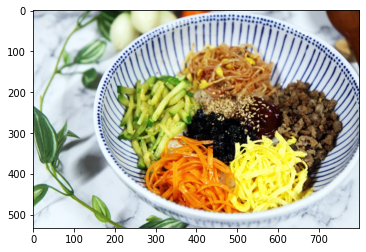

입력 화상의 예측 결과: 비빔밥
입력에 사용된 이미지


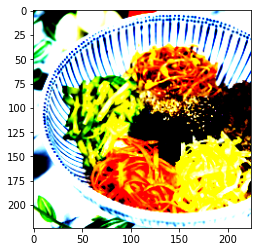

In [57]:
# Predictor 인스턴스 생성
predictor = Predictor(class_index)

# 입력 화상 읽기
image_file_path = '../img_data/IMG_9895.jpg'
img = Image.open(image_file_path) # [높이][너비][색RGB]
plt.imshow(img)
plt.show()

# 전처리 후 배치 크기의 차원 추가
resize = 224
transform = ImageTransform(resize, mean, std) # 전처리 클래스 작성
img_transformed = transform(img, phase='val') # torch.Size([3, 224, 224]) [색RGB][높이][너비]
inputs = img_transformed.unsqueeze_(0) # torch.Size([1, 3, 224, 224])
# 모델에 입력하고 모델 출력을 라벨로 변환
net.to('cpu')
out = net(inputs)
result = predictor.predict_max(out)

# 예측 결과 출력
print('입력 화상의 예측 결과:', result)
print('입력에 사용된 이미지')
img_transformed.squeeze_(0) # torch.Size([3, 224, 224])

# (색상, 높이, 너비)를 (높이, 너비, 색상)으로 변환하고 0-1로 값을 제한해 표시
img_transformed = img_transformed.numpy().transpose((1, 2, 0)) # torch.Size([224, 224, 3])
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()

### 학습한 네트워크 저장 및 로드

In [27]:
# 파이토치 네트워크 파라미터 저장
save_path = './weights_fine_tuning.pth'
torch.save(net.state_dict(), save_path)

In [ ]:
# 파이토치 네트워크 파라미터 로드
load_path = './weights_fine_tuning.pth'
load_weights = torch.load(load_path)
net.load_state_dict(load_weights)

# GPU상에 저장된 가중치를 CPU에 로드할 경우
load_weights = torch.load(load_path, map_location={'cuda':'cpu'})
net.load_state_dict(load_weights)